In [71]:
import networkx as nx
import pandas as pd
import numpy as np
import random
import wikipedia
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from node2vec import Node2Vec
from sklearn.decomposition import PCA

In [72]:
edge_list = pd.read_csv("small_data.tsv", sep = "\t")
edge_list.head()

,source,target,depth
0,space research,advances in space research,1
1,space research,benefits of space exploration,1
2,space research,committee on space research,1
3,space research,deep space exploration,1
4,space research,lists of space programs,1


In [73]:
graph = nx.from_pandas_edgelist(edge_list, "source", "target", edge_attr=True)
print("Number of nodes: ", len(graph))

Number of nodes:  2096


In [74]:
class Deepwalk():
    """DeepWalk algorithm"""
    
    def __init__(self, graph, walk_length=10, num_walks=5):
        """Inits a Deepwalk instance.
        
        Args:
            graph: graph to embed
            walk_length: number of steps per walk
            num_walks: number of walks per starting node
        """
        
        self.graph = graph
        self.walk_length = walk_length
        self.num_walks = num_walks
        
        self.walks = []

        for node in graph.nodes():
            for i in range(self.num_walks):
                self.walks.append(self.build_walk(node))
        
    def build_walk(self, node, repeat_nodes=True):
    
        walk = [node]
    
        for i in range(self.walk_length-1):
            neighbors = list(self.graph.neighbors(node))
            if not repeat_nodes:
                neighbors = list(set(neighbors)-set(walk))
            if len(neighbors) == 0:
                break
            next_node = random.choice(neighbors)
            walk.append(next_node)
            node = next_node

        return walk
    
    def fit(self, window=5, size=100, min_count=5, sg=1, hs=0, negative=10, iter=20):
        """Train Word2Vec model with skip-gram and negative sampling based on pre-computed walks"""
        return Word2Vec(self.walks, size=size, window=window, 
                        min_count=min_count, sg=sg, hs=hs, negative=negative, iter=iter)

In [75]:
deepwalk = Deepwalk(graph, walk_length=10, num_walks=5)
deepwalk_model = deepwalk.fit(window=5, size=100, min_count=5, sg=1, hs=0, negative=10, iter=20)

In [89]:
node2vec = Node2Vec(graph, walk_length=10, num_walks=5, quiet=True)
node2vec_model = node2vec.fit(window=5, size=100, min_count=5, sg=1, hs=0, negative=10, iter=20)

In [77]:
deepwalk_model.wv.similar_by_word('space tourism')

[('space flight participant', 0.7651218175888062),
 ('rocketship tours', 0.7161263227462769),
 ('reduced-gravity aircraft', 0.7084771394729614),
 ('micro-g environment', 0.7053091526031494),
 ('space tourism society', 0.6852333545684814),
 ('astronaut training', 0.680614173412323),
 ('commercial astronaut', 0.6591927409172058),
 ('space adventures', 0.6570894718170166),
 ('environmental impact of aviation', 0.6376293897628784),
 ('renal stone formation in space', 0.6299538612365723)]

In [90]:
node2vec_model.wv.similar_by_word('space tourism')

[('space flight participant', 0.7478160858154297),
 ('reduced-gravity aircraft', 0.6644715666770935),
 ('astronaut training', 0.6591353416442871),
 ('space tourism society', 0.6091874837875366),
 ('micro-g environment', 0.592137336730957),
 ('rocketship tours', 0.5817957520484924),
 ('starchaser industries', 0.5586233735084534),
 ('nuclear powers', 0.5579135417938232),
 ('commercial astronaut', 0.5508224368095398),
 ('space adventures', 0.5436766743659973)]

In [79]:
nodes_to_plot = ['lunar escape systems','soviet moonshot', 'soyuz 7k-l1', 
                 'moon landing','space food', 'food systems on space exploration missions', 
                 'meal, ready-to-eat','space law', 'metalaw', 'moon treaty', 
                 'legal aspects of computing','astronaut training', 'reduced-gravity aircraft', 
                 'space adaptation syndrome', 'micro-g environment']

In [80]:
def plot_pca(model, nodes, dim=2):
    word_vectors = model.wv[nodes]
    
    pca = PCA(n_components=dim)
    projections = pca.fit_transform(word_vectors)
    
    
    plt.figure(figsize=(10,7))
    plt.scatter(projections[:,0], projections[:,1])
    for i, node in enumerate(nodes):
        plt.annotate(node, xy=(projections[i,0], projections[i,1]))
    plt.title("PCA over first {} components".format(dim))
    plt.show()

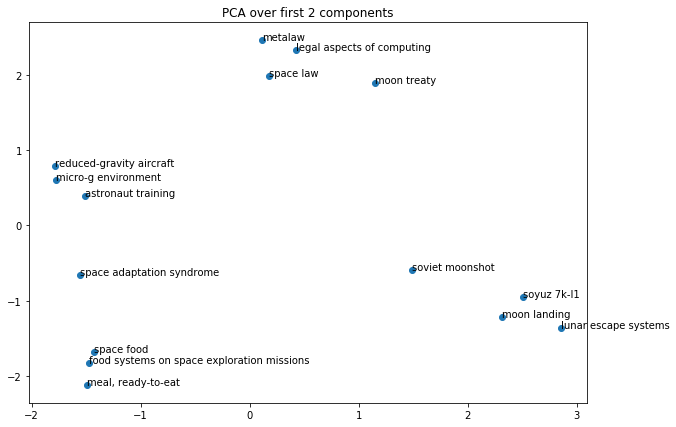

In [81]:
plot_pca(deepwalk_model, nodes_to_plot)

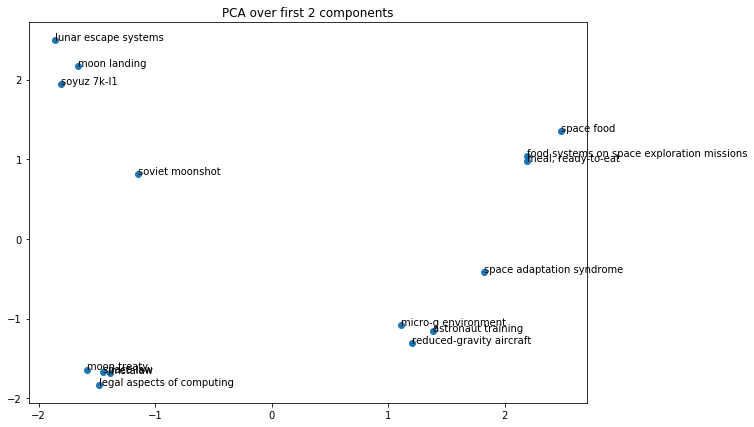

In [91]:
plot_pca(node2vec_model, nodes_to_plot)

In [83]:
def get_url(node):
    return "https://en.wikipedia.org/wiki/" + node.replace(" ", "_")

urls = [get_url(node) for node in graph.nodes()]

In [84]:
def get_summary(node, num_chars=1000):
    try:
        return wikipedia.summary(node, chars=num_chars)[:num_chars] # summary may not exactly return num_chars
    except:
        return ''

In [85]:
# Scrapping summary for each article
# Requests are done sequentially and each request takes ~1 sc
#summaries = [get_summary(node, num_chars=1) for node in graph.nodes()]